In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display


import itertools

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
import numpy as np

import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs

# Options

In [2]:
regions = ['SEA', 'Indo','Malay','all_countries','Viet','Cambod']
months = ['Jan','Apr','July', 'Oct'] #options are Jan, Apr, July, Oct
time = '2016'
#compare_2x = True #True allows for comparison to the 2x simulation to see the performance of the GF; False just creates a new GF
#global_mean = True #False turns on a spatially explicit version with lat and lon; True turns on a global weighted mean
length_simulation = 60 #days
diagnostic = 'SpeciesConc'


In [3]:
for m in months:
    print(m)

Jan
Apr
July
Oct


## Import monthly data for 2x

In [4]:
dict_conc = {}
dict_emis = {}

In [5]:
pulse_size = '2x'
for r in regions:
    for m in months:
        print(m)
        print(r)
        #2x pulse for GF
        dict_conc[r + '_' + m] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_{pulse_size}_pulse/{r}/{m}/mod_output/GEOSChem.SpeciesConc.{time}*', combine = 'by_coords')
        #2x pulse for GF
        dict_emis[r + '_' + m] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_{pulse_size}_pulse/{r}/{m}/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')
        if (dict_conc[r + '_' + m]['time'].diff('time').astype('float64') > 86400000000000).any():
            print('CHECK TIME, FAILED')

for m in months:
    dict_conc[f'base_{m}'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/{m}/mod_output/GEOSChem.SpeciesConc.{time}*', combine = 'by_coords', engine = 'netcdf4')
    dict_emis[f'base_{m}'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/{m}/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords', engine = 'netcdf4')
    if (dict_conc[f'base_{m}']['time'].diff('time').astype('float64') > 86400000000000).any():
            print('CHECK TIME, FAILED')


Jan
SEA
Apr
SEA
July
SEA
Oct
SEA
Jan
Indo
Apr
Indo
July
Indo
Oct
Indo
Jan
Malay
Apr
Malay
July
Malay
Oct
Malay
Jan
all_countries
Apr
all_countries
July
all_countries
Oct
all_countries
Jan
Viet
Apr
Viet
July
Viet
Oct
Viet
Jan
Cambod
Apr
Cambod
July
Cambod
Oct
Cambod


## Import 16x for comparison

In [6]:
pulse_size = '16x'
for r in regions:
    for m in ['Jan']:
        #2x pulse for GF
        dict_conc[r + '_' + m + '_' + pulse_size] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_{pulse_size}_pulse/{r}/{m}/mod_output/GEOSChem.SpeciesConc.{time}*', combine = 'by_coords')
        #2x pulse for GF
        dict_emis[r + '_' + m+ '_' + pulse_size] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_{pulse_size}_pulse/{r}/{m}/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')
        
        if (dict_conc[r + '_' + m + '_' + pulse_size]['time'].diff('time').astype('float64') > 86400000000000).any():
            print('CHECK TIME, FAILED-- Check the regridding as not all times were regridded')

In [7]:
for m in months:
    dict_conc[f'all_countries_summed_{m}'] = dict_conc[f'Indo_{m}'] + dict_conc[f'Malay_{m}'] + dict_conc[f'Viet_{m}'] + dict_conc[f'Cambod_{m}']

## Import Data across January Comparison

In [8]:
days = ['6', '11', '16', '21', '26']
pulse_size = '2x'
for d in days:
    print(d)
    #2x pulse for GF
    dict_conc['Indo_Jan_' + d] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_{pulse_size}_pulse/Jan_uncertainty_Indo/Jan{d}_pulse/mod_output/GEOSChem.SpeciesConc.{time}*', combine = 'by_coords')
    #2x pulse for GF
    dict_emis['Indo_Jan_' + d] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_{pulse_size}_pulse/Jan_uncertainty_Indo/Jan{d}_pulse/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')
    
    if (dict_conc['Indo_Jan_' + d]['time'].diff('time').astype('float64') > 86400000000000).any():
        print('CHECK TIME, FAILED-- Check the regridding as not all times were regridded')
        
for d in days:
    dict_conc[f'base_Jan_{d}'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan{d}_pulse/mod_output/GEOSChem.SpeciesConc.{time}*', combine = 'by_coords', engine = 'netcdf4')
    dict_emis[f'base_Jan_{d}'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/Jan{d}_pulse/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords', engine = 'netcdf4')

6
11
16
21
26


## Import Data across Indonesia location comparison

In [6]:
locations = ['Center','NW','SE']
pulse_size = '2x'
for loc in locations:
    print(loc)
    #2x pulse for GF
    dict_conc['Indo_Jan_' + loc] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_{pulse_size}_pulse/loc_uncertainty_Indo/{loc}_pulse/mod_output/GEOSChem.SpeciesConc.{time}*', combine = 'by_coords')
    #2x pulse for GF
    dict_emis['Indo_Jan_' + loc] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_{pulse_size}_pulse/loc_uncertainty_Indo/{loc}_pulse/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')
    if (dict_conc['Indo_Jan_' + loc]['time'].diff('time').astype('float64') > 86400000000000).any():
        print('CHECK TIME, FAILED-- Check the regridding as not all times were regridded')

Center
NW
SE


## Make dataset and modify time

In [10]:
#shift our time so that it is halfway through the day to represent the daily mean
for i in dict_emis.keys():
    utils.switch_conc_time(dict_emis[i])
    #shift our time so that it is halfway through the day to represent the daily mean
for i in dict_conc.keys():
    utils.switch_conc_time(dict_conc[i])

In [11]:
for i in dict_emis.keys():
    #change the time to be delta time
    dict_conc[i]['time'] = dict_conc[i]['time']-dict_conc[i]['time'][0]
    dict_emis[i]['time'] = dict_emis[i]['time']-dict_emis[i]['time'][0]
    #combine the BCPI and BCPO emissions
    utils.combine_BC(dict_emis[i])
    #fix the area
    dict_emis[i] = utils.fix_area_ij_latlon(dict_emis[i])
    dict_conc[i]= utils.fix_area_ij_latlon(dict_conc[i])
    dict_conc[i]['BC_total'] = dict_conc[i]['SpeciesConc_BCPI'] + dict_conc[i]['SpeciesConc_BCPO']


## Add height to data

In [12]:
height = pd.read_excel('gc_72_estimate.xlsx', index_col = 0)

In [13]:
height = height.reindex(index=height.index[::-1])

In [14]:
height_ds = height.diff().dropna().to_xarray().rename({'L':'lev'})
height_ds = height_ds.rename({'Altitude (km)':'dz'}) 
height_ds['dz']*=1e3 #convert to meters
height_ds['dz'].attrs = {'units':'m'}

In [15]:
sec_day = 86400

## Define our Conc Difference and Initial Forcing

In [16]:
poll_name = 'BC_total'
dt = 1 #day

In [17]:
f0 = {}

In [18]:
for r in regions:
    for m in months:
        f0[r + '_' + m] = (dict_emis[r + '_' + m]['EmisBC_Total'].weighted(dict_emis[r + '_' + m]['area'].fillna(0)).sum(dim = ['lat','lon']) - 
                dict_emis[f'base_{m}']['EmisBC_Total'].weighted(dict_emis[f'base_{m}']['area'].fillna(0)).sum(dim = ['lat','lon'])).isel(lev = -1).isel(time = 0).values


In [19]:
for m in months:
    f0[f'all_countries_summed_{m}'] = f0[f'Indo_{m}'] + f0[f'Malay_{m}'] + f0[f'Viet_{m}'] + f0[f'Cambod_{m}']

In [20]:
m = 'Jan'
for r in regions:
    f0[r + '_' + m + '_16x'] = (dict_emis[r + '_' + m + '_16x']['EmisBC_Total'].weighted(dict_emis[r + '_' + m + '_' + '16x']['area'].fillna(0)).sum(dim = ['lat','lon']) - 
            dict_emis[f'base_{m}']['EmisBC_Total'].weighted(dict_emis[f'base_{m}']['area'].fillna(0)).sum(dim = ['lat','lon'])).isel(lev = -1).isel(time = 0).values


In [21]:
days

['6', '11', '16', '21', '26']

In [22]:
for d in days:
    f0[f'Indo_Jan_{d}'] = (dict_emis[f'Indo_Jan_{d}']['EmisBC_Total'].weighted(dict_emis[f'Indo_Jan_{d}']['area'].fillna(0)).sum(dim = ['lat','lon']) - 
            dict_emis[f'base_Jan_{d}']['EmisBC_Total'].weighted(dict_emis[f'base_Jan_{d}']['area'].fillna(0)).sum(dim = ['lat','lon'])).isel(lev = -1).isel(time = 0).values



In [23]:
for d in locations:
    f0['Indo_Jan_' + d] = (dict_emis['Indo_Jan_' + d]['EmisBC_Total'].weighted(dict_emis['Indo_Jan_' + d]['area']).sum(dim = ['lat','lon']) - 
            dict_emis['base_Jan']['EmisBC_Total'].weighted(dict_emis['base_Jan']['area']).sum(dim = ['lat','lon'])).isel(lev = -1).isel(time = 0).values


In [24]:
#calculate the Green's function as dc/f0
G_dict = {}
G_dict_gmean = {}
regions = ['SEA', 'Indo','Malay','all_countries','Viet','Cambod']


In [25]:
for r in regions:
    for m in months:
        G_dict[r + '_' + m] = (dict_conc[r + '_' + m]-dict_conc[f'base_{m}'])['BC_total']/f0[r + '_' + m]
        G_dict_gmean[r + '_' + m] = (dict_conc[r + '_' + m]-dict_conc[f'base_{m}'])['BC_total'].weighted(
            dict_conc[f'base_{m}']['area'].fillna(0)*height_ds['dz'].fillna(0)).mean(['lat','lon','lev'])/f0[r + '_' + m]


In [26]:
for m in months:
    G_dict[f'all_countries_summed_{m}'] = (((dict_conc['Indo_' + m]-dict_conc[f'base_{m}'])['BC_total']+ 
                                          (dict_conc['Malay_' + m]-dict_conc[f'base_{m}'])['BC_total']+
                                          (dict_conc['Viet_' + m]-dict_conc[f'base_{m}'])['BC_total']+
                                          (dict_conc['Cambod_' + m]-dict_conc[f'base_{m}'])['BC_total'])/
                                           (f0['Indo_Jan'] + f0['Viet_Jan'] + f0['Malay_Jan'] + f0['Cambod_Jan']))
    G_dict_gmean[f'all_countries_summed_{m}'] = (((dict_conc['Indo_' + m]-dict_conc[f'base_{m}'])['BC_total']+ 
                                          (dict_conc['Malay_' + m]-dict_conc[f'base_{m}'])['BC_total']+
                                          (dict_conc['Viet_' + m]-dict_conc[f'base_{m}'])['BC_total']+
                                          (dict_conc['Cambod_' + m]-dict_conc[f'base_{m}'])['BC_total']).weighted(
        dict_conc[f'base_{m}']['area'].fillna(0)*height_ds['dz'].fillna(0)).mean(['lat','lon','lev'])/
 (f0['Indo_Jan'] + f0['Viet_Jan'] + f0['Malay_Jan'] + f0['Cambod_Jan']))
    
    

In [27]:
m = 'Jan'
for r in regions:
    G_dict[r + '_' + m + '_16x'] = (dict_conc[r + '_' + m + '_16x']-dict_conc[f'base_{m}'])['BC_total']/f0[r + '_' + m + '_16x']
    G_dict_gmean[r + '_' + m + '_16x'] = (dict_conc[r + '_' + m]-dict_conc[f'base_{m}'])['BC_total'].weighted(
        dict_conc[f'base_{m}']['area'].fillna(0)*height_ds['dz'].fillna(0)).mean(['lat','lon','lev'])/f0[r + '_' + m + '_16x']


In [28]:
for d in days:
    G_dict['Indo_Jan_' + d] = (dict_conc['Indo_Jan_' + d]-dict_conc[f'base_Jan_{d}'])['BC_total']/f0['Indo_Jan_' + d]
    G_dict_gmean['Indo_Jan_' + d] = (dict_conc['Indo_Jan_' + d]-dict_conc[f'base_Jan_{d}'])['BC_total'].weighted(
        dict_conc[f'base_Jan_{d}']['area'].fillna(0)*height_ds['dz'].fillna(0)).mean(['lat','lon','lev'])/f0['Indo_Jan_' + d]


In [29]:
for d in locations:
    G_dict['Indo_Jan_' + d] = (dict_conc['Indo_Jan_' + d]-dict_conc[f'base_Jan'])['BC_total']/f0['Indo_Jan_' + d]
    G_dict_gmean['Indo_Jan_' + d] = (dict_conc['Indo_Jan_' + d]-dict_conc[f'base_Jan'])['BC_total'].weighted(
        dict_conc[f'base_Jan']['area'].fillna(0)*height_ds['dz'].fillna(0)).mean(['lat','lon','lev'])/f0['Indo_Jan_' + d]


## Add tail to zero based on the mean at that level

In [30]:
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [31]:
for r in ['all_countries_summed_Jan', 'all_countries_summed_Apr', 'all_countries_summed_July', 'all_countries_summed_Oct']:
    dict_conc[r]= utils.fix_area_ij_latlon(dict_conc[r])

In [32]:
for r in ['all_countries_summed_Jan', 'all_countries_summed_Apr', 'all_countries_summed_July', 'all_countries_summed_Oct']:
    dict_conc[r]['time'] = dict_conc[r]['time']-dict_conc[r]['time'][0]

In [33]:
full_ds = {}
for r in G_dict.keys():   
    tail_add = (G_dict[r].weighted(dict_conc[r]['area']).mean(dim = ['lat','lon'])/
     G_dict[r].weighted(dict_conc[r]['area']).mean(dim = ['lat','lon']).isel(time = 0))

    adj_tail_add = (G_dict[r].isel(time = -1)*tail_add)

    adj_tail_add['time'] = adj_tail_add['time'] + adj_tail_add['time'][-1] #+ pd.Timedelta('1 day')

    full_ds[r] = xr.merge([G_dict[r], adj_tail_add])

## Create different Green's Functions

In [34]:
#convert to datasets, calculate mean GF
G = xr.concat([full_ds[r] for r in full_ds.keys()], pd.Index([r for r in full_ds.keys()], name='run'))
G_mean = xr.concat([G_dict_gmean[r] for r in G_dict_gmean.keys()], pd.Index([r for r in G_dict_gmean.keys()], name='run'))


## Save out the Green's function

In [ ]:
G.to_netcdf(f'Outputs/G_all_loc_all_times_{poll_name}.nc4', mode = 'w')
G_mean.to_netcdf(f'Outputs/G_mean_all_loc_all_times_{poll_name}.nc4',  mode = 'w')

## Global mean GF Plot

Text(0, 0.5, "Global Mean Surface \n Green's Function")

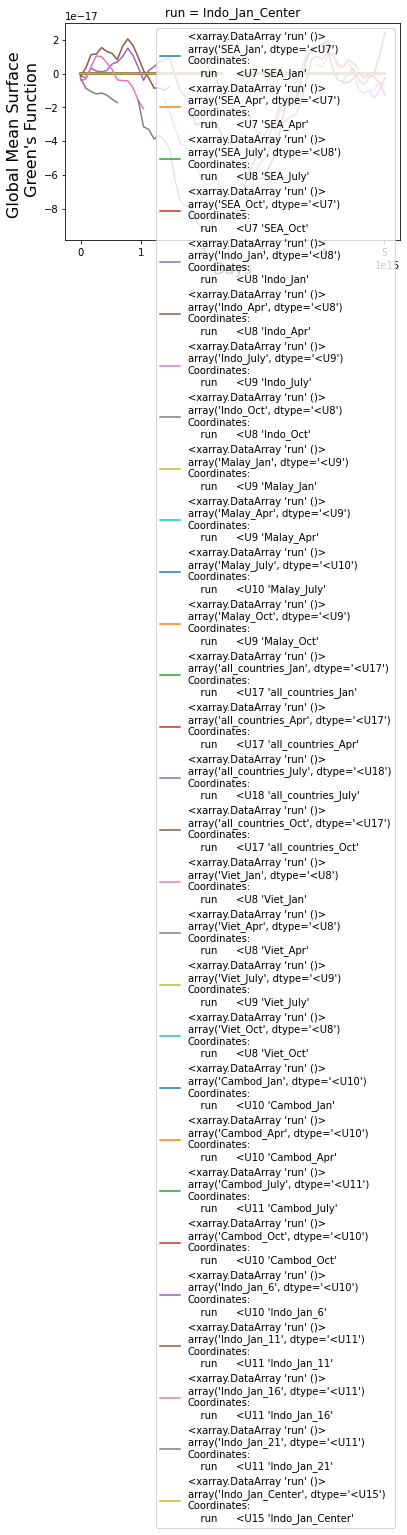

In [29]:
for r in G_mean.run:
    G_mean.sel(run = r).plot(label = r)
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)

Text(0.5, 1.0, 'Pulse from Indonesia at Dif Locations')

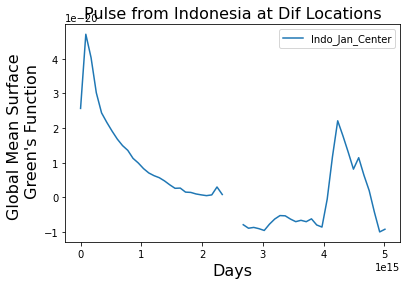

In [63]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
for r in ['Indo_Jan_Center']:
    G_mean.sel(run = r).plot(label = r)
#plt.ylim(0,1e-20)
#plt.xlim(0,10)
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title("Pulse from Indonesia at Dif Locations", fontsize = 16)
#plt.savefig('figures/IGAC/global_mean_SEA_month_comp.png', dpi = 250, bbox_inches = 'tight')

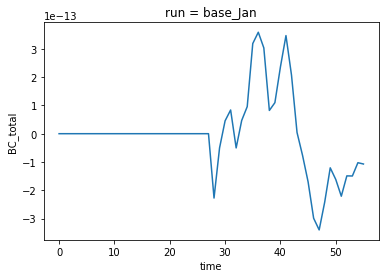

In [34]:
((ds_conc.sel(run ='Indo_Jan_Center')-ds_conc.sel(run =f'base_Jan'))['BC_total'].weighted(
        ds_conc['area'].sel(run = f'base_Jan').fillna(0)*ds_conc['dz'].fillna(0)).mean(['lat','lon','lev'])/f0['Indo_Jan_Center']).plot()

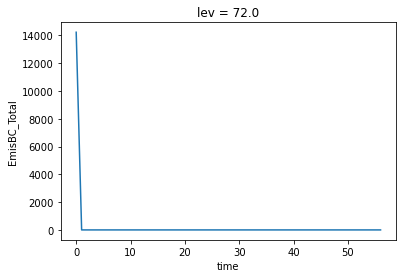

In [91]:
(ds_emis['EmisBC_Total'].weighted(ds_emis['area'].fillna(0)).sum(dim = ['lat','lon']).sel(run = 'Indo_Jan') - 
            ds_emis['EmisBC_Total'].weighted(ds_emis['area'].fillna(0)).sum(dim = ['lat','lon']).sel(run = f'base_Jan')).plot()

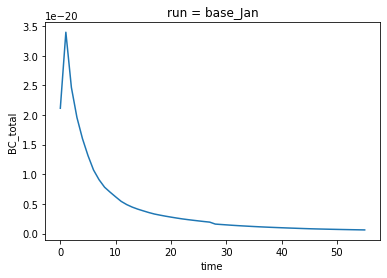

In [84]:
((ds_conc.sel(run ='Indo_Jan')-ds_conc.sel(run =f'base_Jan'))['BC_total'].weighted(
        ds_conc['area'].sel(run = f'base_Jan').fillna(0)*ds_conc['dz'].fillna(0)).mean(['lat','lon','lev'])/f0['Indo_Jan']).plot()

Text(0.5, 1.0, 'Pulse from Indonesia at Dif Times of January')

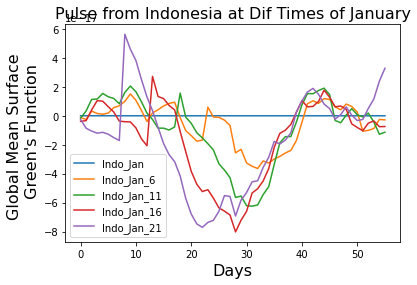

In [77]:
#G_mean.mean(dim = 'run').plot(label = 'Mean')*1e23
for r in ['Indo_Jan','Indo_Jan_6','Indo_Jan_11','Indo_Jan_16','Indo_Jan_21']:
    G_mean.sel(run = r).plot(label = r)

plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title("Pulse from Indonesia at Dif Times of January", fontsize = 16)
#plt.savefig('figures/IGAC/global_mean_SEA_month_comp.png', dpi = 250, bbox_inches = 'tight')

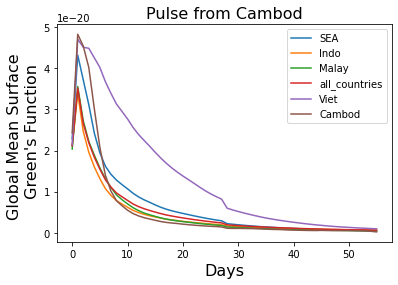

In [73]:
fig, ax = plt.subplots()
m = 'Jan'
for r in regions:
    G_mean.sel(run = r + '_' + m).plot(label = r)

    plt.legend()
    plt.xlabel('Days', fontsize = 16)
    plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
    plt.title(f"Pulse from {r}", fontsize = 16)
   # plt.savefig('figures/IGAC/global_mean_SEA_month_comp.png', dpi = 250, bbox_inches = 'tight')

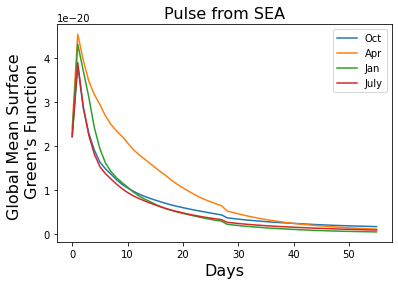

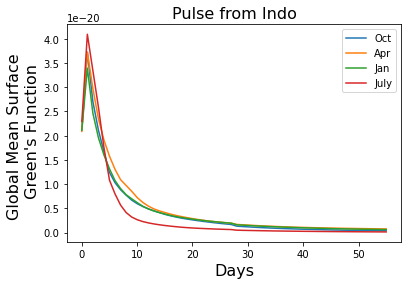

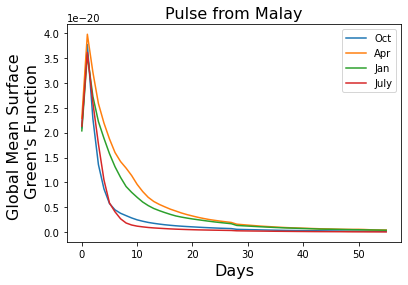

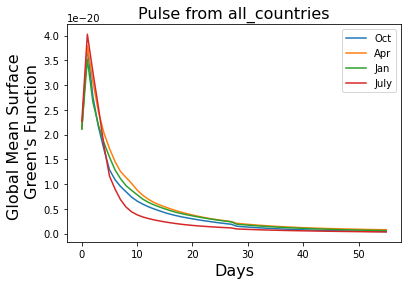

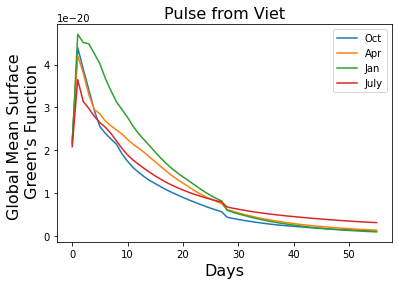

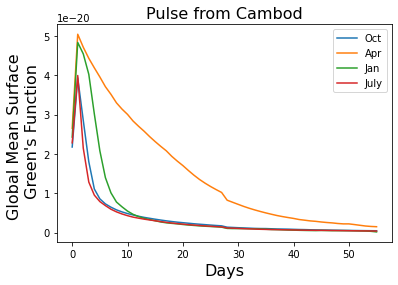

In [75]:
for r in regions:
    fig, ax = plt.subplots()
    for m in ['Oct','Apr','Jan','July']:
        G_mean.sel(run = r + '_' + m).plot(label = m)

        plt.legend()
        plt.xlabel('Days', fontsize = 16)
        plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
        plt.title(f"Pulse from {r}", fontsize = 16)
        plt.savefig(f'figures/global_mean_{r}_month_comp.png', dpi = 250, bbox_inches = 'tight')

In [29]:
G_small = G.sel(run = 'SEA_Jan').isel(lev = 0).rename({'time':'s'})

In [30]:
import dask
def convolve_single_lev(G, E, dt):
    '''convolves a spatially resolved G that is mean or single level with an emissions scenario of any length'''
    E_len = len(E)
    G_len = len(G.s)
    C = dask.array.empty(((E_len+G_len), len(G.lat), len(G.lon))) 
    for i, tp in enumerate(np.arange(0,E_len)):
        C[i:i+G_len] = C[i:i+G_len]+ G*E[i]*dt #C.loc slice or where
        #print((G*E[i]*dt).values)
        #print(C.compute())
    C = xr.DataArray(
    data = C,
    dims = ['s','lat','lon'],
    coords = dict(
        s = (['s'], np.arange(0,(E_len+G_len))),
        lat = (['lat'], G.lat.values),
        lon = (['lon'], G.lon.values)
            )
        )
    return C

In [31]:
test_conv = convolve_single_lev(G_small, test_emis, 1)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree()})
ds_conc.sel(run = 'base')['BC_total'].isel(lev = -1, time = 50).plot(ax = ax, 
                                                    transform = ccrs.PlateCarree(), 
                                                    levels = np.arange(0,2e-12,1e-14),
                                                    #extend = 'both',
                                                    cmap = 'gist_heat_r', cbar_kwargs = dict(label=''))
ax.coastlines()
ax.set_extent([80,150,-20,40])
ax.set_title(f'Base concentration \n (day 50)', fontsize = 16)

/tmp/ipykernel_7263/3136878309.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, xlim=[-180, 180], ylim=[-90, 90])


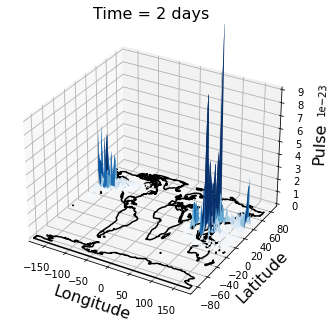

In [92]:
fig = plt.figure()
ax = Axes3D(fig, xlim=[-180, 180], ylim=[-90, 90])
ax.set_zlim(bottom=0)


concat = lambda iterable: list(itertools.chain.from_iterable(iterable))

target_projection = ccrs.PlateCarree()

feature = cartopy.feature.NaturalEarthFeature('physical', 'land', '110m')
geoms = feature.geometries()

geoms = [target_projection.project_geometry(geom, feature.crs)
         for geom in geoms]

paths = concat(geos_to_path(geom) for geom in geoms)

polys = concat(path.to_polygons() for path in paths)

# lc = PolyCollection(polys, edgecolor='black',
#                     facecolor='green', closed=False)
lc = LineCollection(polys, color='black')

ax.add_collection3d(lc)



(G.isel(time = 2, lev = -1)).sel(run = 'SEA_Jan').where((G.isel(time = 2, lev = -1)).sel(run = 'SEA_Jan') > 0.).plot.surface(cmap = 'Blues', ax = ax,  add_colorbar=False, vmin = 0, vmax = .2e-22)

ax.set_xlabel('Longitude', fontsize = 16)
ax.set_ylabel('Latitude', fontsize = 16)
ax.set_zlabel('Pulse', fontsize = 16)
ax.set_title(r'Time = 2 days', fontsize = 16)

ax.set_zlim(0., .9e-22)

plt.savefig('figures/IGAC/pulse_2.png', dpi = 250, bbox_inches = 'tight')

/tmp/ipykernel_7263/821010165.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, xlim=[-180, 180], ylim=[-90, 90])


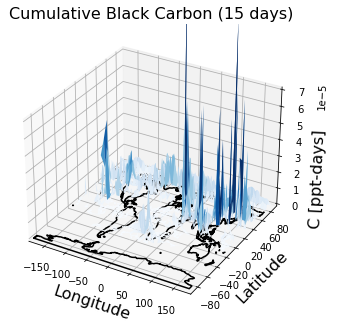

In [146]:
fig = plt.figure()
ax = Axes3D(fig, xlim=[-180, 180], ylim=[-90, 90])
ax.set_zlim(bottom=0)


concat = lambda iterable: list(itertools.chain.from_iterable(iterable))

target_projection = ccrs.PlateCarree()

feature = cartopy.feature.NaturalEarthFeature('physical', 'land', '110m')
geoms = feature.geometries()

geoms = [target_projection.project_geometry(geom, feature.crs)
         for geom in geoms]

paths = concat(geos_to_path(geom) for geom in geoms)

polys = concat(path.to_polygons() for path in paths)

# lc = PolyCollection(polys, edgecolor='black',
#                     facecolor='green', closed=False)
lc = LineCollection(polys, color='black')

ax.add_collection3d(lc)



(1e12*f0['SEA_Jan']*G.isel(time = slice(0,15), lev = -1)).sel(run = 'SEA_Jan').sum(dim = 'time').where(
    (G.isel(time = slice(0,15), lev = -1)).sum(dim = 'time').sel(run = 'SEA_Jan') > 1e-24).plot.surface(
    cmap = 'Blues', ax = ax,  add_colorbar=False, vmin = 0, vmax = 3e-5)

ax.set_xlabel('Longitude', fontsize = 16)
ax.set_ylabel('Latitude', fontsize = 16)
ax.set_zlabel('C [ppt-days]              ', fontsize = 16)
ax.set_title(r'Cumulative Black Carbon (15 days)', fontsize = 16)

ax.set_zlim(0., 7e-5)

plt.savefig('figures/IGAC/pulse_cumul_15.png', dpi = 250, bbox_inches = 'tight')

77926.38874983042

/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/gchp/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


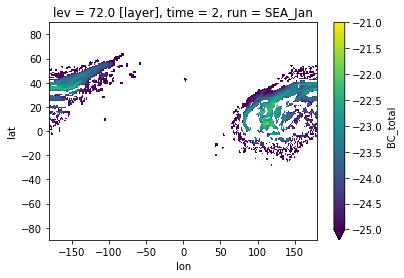

In [60]:
(np.log10(G.isel(time = 2, lev = -1)).sel(run = 'SEA_Jan')).plot(vmin=-25, vmax=-21)

Text(0.5, 1.0, '')

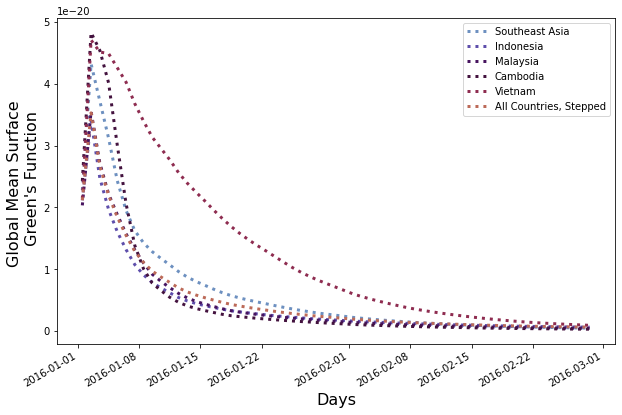

In [35]:
fig, ax = plt.subplots(figsize = [10,6])
color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in regions[:-1]:
    c = next(color)
    
    G_mean.mean(dim = 'run').plot(label = utils.names_dict[r], linestyle = 'dotted', linewidth = 3, c = c)
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title('')
#plt.savefig('figures/G.png', dpi = 200, bbox_inches = 'tight')

Text(0.5, 1.0, '')

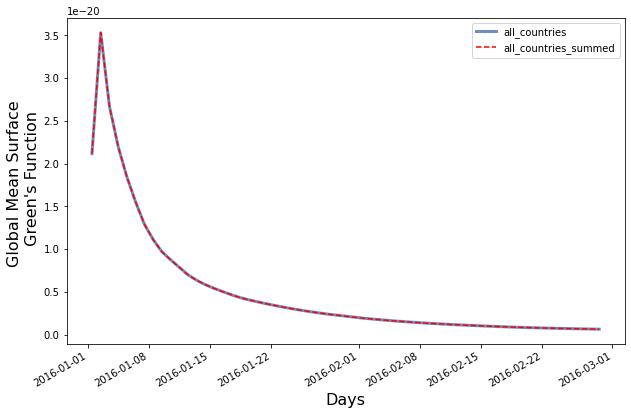

In [25]:
fig, ax = plt.subplots(figsize = [10,6])
color = iter(cm.twilight(np.linspace(.2, .9, 8)))
for r in ['all_countries','all_countries_summed']:
    c = next(color)
    if 'summed' in r:
        G_mean.sel(run = r).plot(label = r, linestyle = 'dashed', c= 'red')
    else:
        G_mean.sel(run = r).plot(label = r, linestyle = 'solid', linewidth = 3, c = c)
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title('')
#plt.savefig('figures/G.png', dpi = 200, bbox_inches = 'tight')

## Location Average test 

In [92]:
ds_emis = ds_emis.rename({'time':'tp'})

In [93]:
ds_emis = ds_emis.assign_coords(tp = np.arange(0,len(ds_emis['tp'])))

In [97]:
ds_emis_gmean = {}
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    ds_emis_gmean[r + '_Jan'] = (ds_emis.sel(run = r+ '_Jan')-
                 ds_emis.sel(run = 'base_Jan'))['EmisBC_Total'].weighted(
    (ds_emis['area'].fillna(0)).sel(run = 'base_Jan')).sum(dim = ['lat','lon']).compute()


In [98]:
G_loc = G.sel(lat = 25, lon = 114, method = 'nearest').isel(lev = 0)

In [99]:
out_mean = {}
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    out_mean[r + '_Jan'] = utils.convolve_global_mean(G_loc.sel(run = r + '_Jan').compute(), ds_emis_gmean[r + '_Jan'], dt = dt, time_dim = 'time')

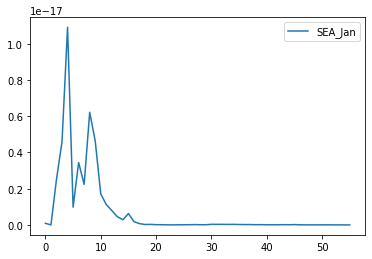

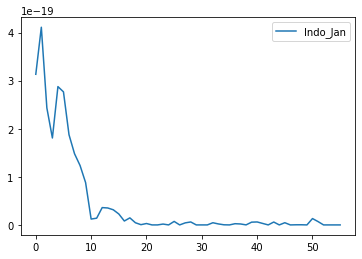

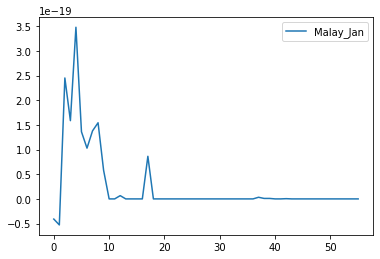

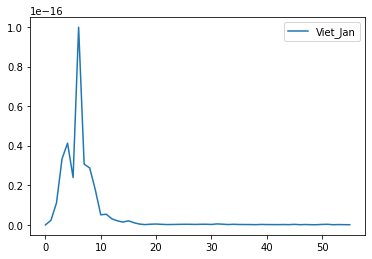

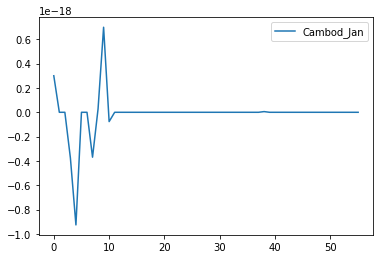

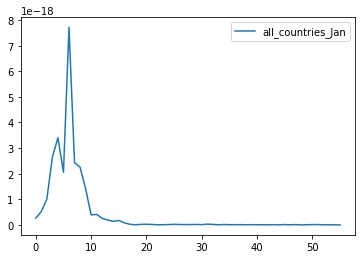

In [102]:

for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    fig, ax = plt.subplots()
    plt.plot(G_loc.sel(run = r + '_Jan'), label = r + '_Jan')
    plt.legend()

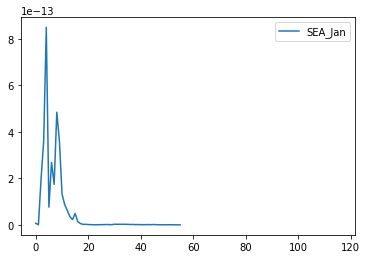

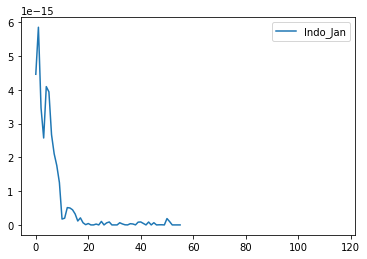

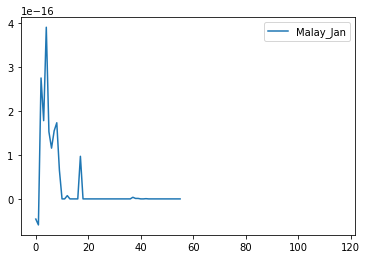

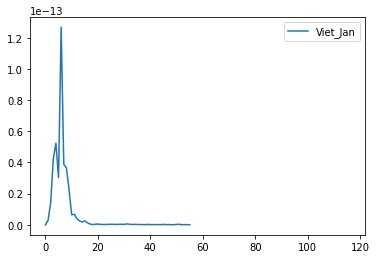

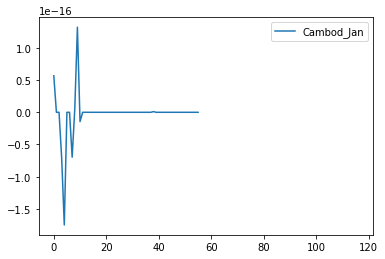

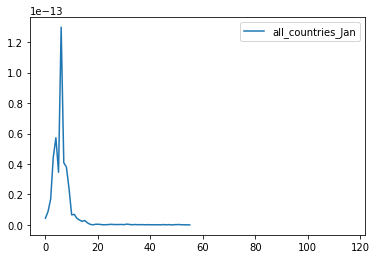

In [101]:
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    fig, ax = plt.subplots()
    plt.plot(out_mean[r + '_Jan'], label = r + '_Jan')
    plt.legend()

## Global Mean Test

In [71]:
out_gmean = {}
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    out_gmean[r] = utils.convolve_global_mean(G_mean.sel(run = r).compute(), ds_emis_gmean[r], dt = dt, time_dim = 'time')

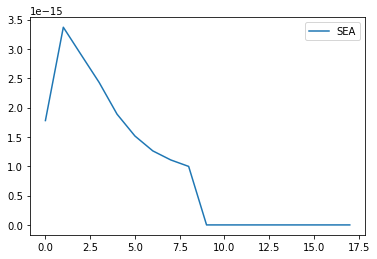

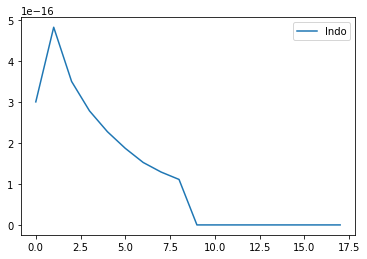

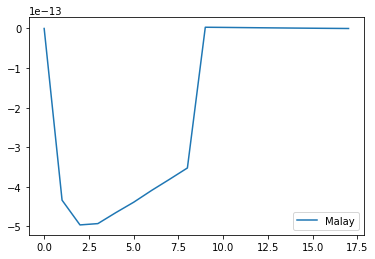

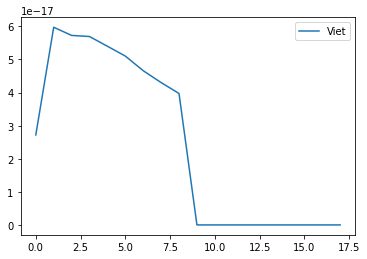

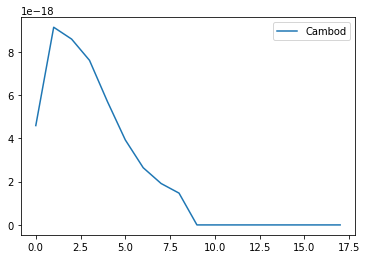

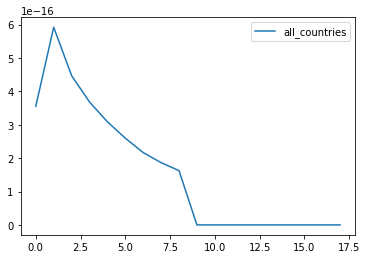

In [75]:
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    fig, ax = plt.subplots()
    plt.plot(out_gmean[r], label = r)
    plt.legend()

# Plots

Text(0.5, 1.0, '')

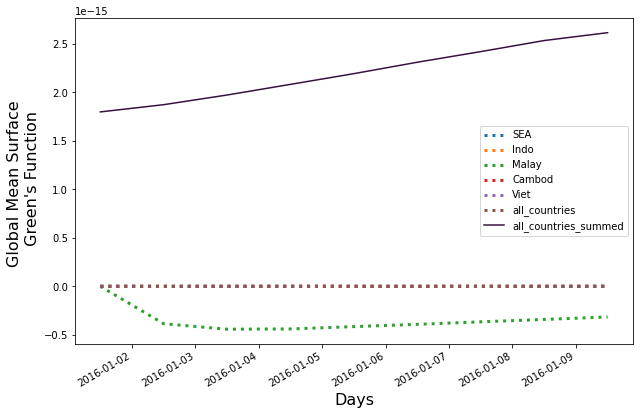

In [100]:
G_mean

<xarray.DataArray 'BC_total' (run: 7, time: 9)>
dask.array<concatenate, shape=(7, 9), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01T12:00:00 ... 2016-01-09T12:00:00
  * run      (run) object 'SEA' 'Indo' ... 'all_countries_summed'

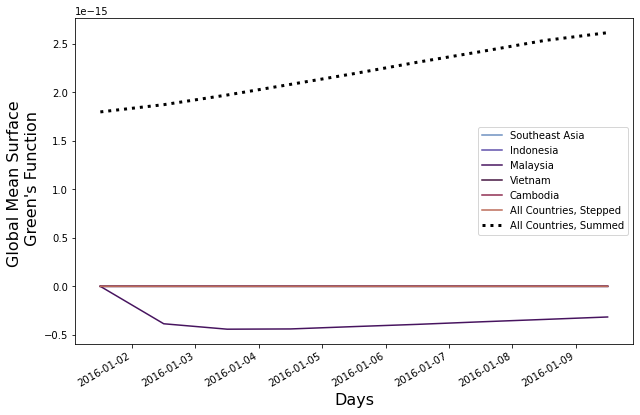

In [99]:

fig, ax = plt.subplots(figsize = [10,6])
color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries', 'all_countries_summed']:
    c = next(color)
    if r != 'all_countries_summed':
        G_mean.sel(run = r).plot(label = utils.names_dict[r], linestyle = 'solid', c= c)
    else:
        G_mean.sel(run = r).plot(label = 'All Countries, Summed', linestyle = 'dotted', c= 'black', linewidth = 3)
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title('')
plt.savefig('figures/G_spatial_comp.png', dpi = 200, bbox_inches = 'tight')

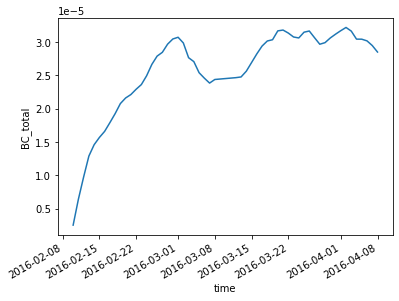

In [113]:
r = 'all_countries'
((utils.global_w_mean(ds_conc.sel(run = r + '_2x').fillna(0), poll_name)-utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name))*1e9).plot()

In [ ]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,4])

color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in ['SEA', 'Indo']:
    c = next(color)
    ax1.plot((utils.global_w_mean(ds_conc.sel(run = r + '_2x').fillna(0), poll_name)-
            utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name))*1e9, color = c)
    ax1.plot(out_gmean[r]*1e9, label = utils.names_dict[r], linestyle = ':', linewidth = 3, color = c)

#ax1.legend(fontsize = 12)
ax1.set_ylabel('Global Mean Concentration (ppt)', fontsize = 18)
ax1.set_xlabel('Days', fontsize = 18)
ax1.set_xlim(0,60)


color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in ['SEA', 'Indo']:
    c = next(color)
    ax2.plot((ds_conc.sel(run = r + '_2x')-ds_conc.sel(run = 'base')).sel(lat = 25, lon = 114, method = 'nearest').fillna(0).isel(lev = 0)['BC_total']*1e9, 
             color = c)
    ax2.plot(out_mean[r]*1e9, label = utils.names_dict[r], linestyle = ':', linewidth = 3, color = c)

#ax2.legend(fontsize = 12)
ax2.set_xlim([0,50])
ax2.set_xlim(0,60)
ax2.set_ylabel('Location Specific Concentration (ppt)', fontsize = 18)
ax2.set_xlabel('Days', fontsize = 18)
ax2.set_yscale("log")  


color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in ['SEA', 'Indo']:
    c = next(color)
    if r != 'all_countries_summed':
        G_mean.sel(run = r).plot(ax = ax3, label = utils.names_dict[r], linestyle = 'solid', c= c)
    else:
        G_mean.sel(run = r).plot(ax = ax3, label = 'All Countries, Summed', linestyle = 'dotted', c= 'black', linewidth = 3)
ax3.legend()
ax3.set_xlabel('Days', fontsize = 16)
ax3.set_ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
ax3.set_title('')
ax3.set_xlim(0,60)

plt.tight_layout()

#plt.savefig('figures/loc_avg_jan.png', bbox_inches = 'tight', dpi = 200)

(1.5e-13, 2e-13)

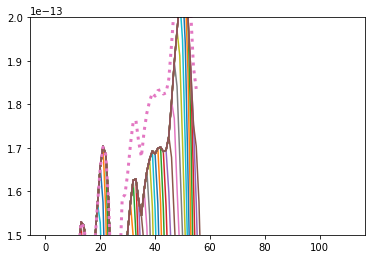

In [37]:
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), np.ones(len(ds_emis_gmean['SEA']))*ds_emis_gmean['SEA'][0].values, dt = dt)
plt.plot((utils.global_w_mean(ds_conc.sel(run = 'SEA_2x').fillna(0), poll_name)-
            utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name)), linestyle = ':', linewidth = 3)
plt.ylim(1.5e-13,2.0e-13)

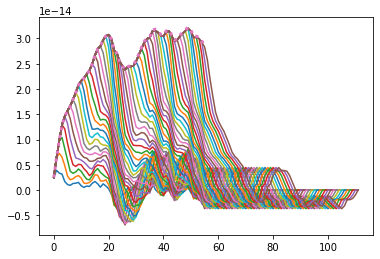

In [43]:
utils.convolve_global_mean(G_mean.sel(run = 'all_countries').compute(), ds_emis_gmean['all_countries'], dt = dt)
plt.plot((utils.global_w_mean(ds_conc.sel(run = 'all_countries_2x').fillna(0), poll_name)-
            utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name)), linestyle = ':', linewidth = 3)

<xarray.DataArray (s: 112)>
array([ 1.28277446e-14,  3.62223337e-14,  5.76822234e-14,  7.72638665e-14,
        9.04643790e-14,  1.01862593e-13,  1.14089699e-13,  1.26618541e-13,
        1.38402173e-13,  1.42242655e-13,  1.38418652e-13,  1.37927428e-13,
        1.46135771e-13,  1.52956677e-13,  1.52094363e-13,  1.47661461e-13,
        1.45475822e-13,  1.42392296e-13,  1.48133953e-13,  1.57114440e-13,
        1.65617190e-13,  1.70329357e-13,  1.68536843e-13,  1.58140141e-13,
        1.40067006e-13,  1.34660863e-13,  1.34872101e-13,  1.40579591e-13,
        1.45041224e-13,  1.45954198e-13,  1.50750210e-13,  1.57305843e-13,
        1.62538884e-13,  1.62828843e-13,  1.57892070e-13,  1.54418846e-13,
        1.60322297e-13,  1.64601855e-13,  1.67393729e-13,  1.69275697e-13,
        1.68593336e-13,  1.69894659e-13,  1.70153695e-13,  1.69130962e-13,
        1.69414240e-13,  1.72648825e-13,  1.80610387e-13,  1.89610602e-13,
        1.96939499e-13,  2.03977906e-13,  2.07675600e-13,  2.06910632e-13,
        1.99979738e-13,  1.88040097e-13,  1.75333886e-13,  1.70333573e-13,
        1.57506351e-13,  1.34113166e-13,  1.12654318e-13,  9.30734883e-14,
        7.98734737e-14,  6.84759540e-14,  5.62499204e-14,  4.37220778e-14,
        3.19388136e-14,  2.80983037e-14,  3.19218932e-14,  3.24129690e-14,
        2.42051815e-14,  1.73846202e-14,  1.82468641e-14,  2.26795536e-14,
        2.48650375e-14,  2.79481689e-14,  2.22063738e-14,  1.32258848e-14,
        4.72320807e-15,  1.08961076e-17,  1.80306754e-15,  1.21991673e-14,
        3.02716066e-14,  3.56781576e-14,  3.54677266e-14,  2.97609053e-14,
        2.52987499e-14,  2.43843715e-14,  1.95873188e-14,  1.30308713e-14,
        7.79733285e-15,  7.50667998e-15,  1.24423805e-14,  1.59146046e-14,
        1.00107865e-14,  5.73125551e-15,  2.93979473e-15,  1.05797548e-15,
        1.73978071e-15,  4.38113253e-16,  1.79146884e-16,  1.20209319e-15,
        9.18969098e-16, -2.31522116e-15, -1.02766440e-14, -1.92768577e-14,
       -2.66058277e-14, -3.36440897e-14, -3.73414412e-14, -3.65758707e-14,
       -2.96442813e-14, -1.77050484e-14, -4.99964415e-15,  0.00000000e+00])
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 7 8 ... 103 104 105 106 107 108 109 110 111

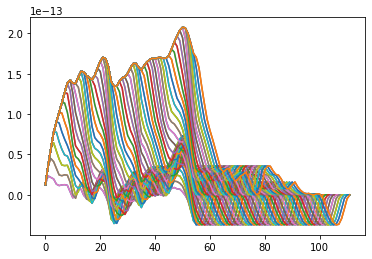

In [125]:
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), np.ones(len(ds_emis_gmean['SEA']))*ds_emis_gmean['SEA'][0].values, dt = dt)
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), ds_emis_gmean['SEA'], dt = dt)


<xarray.DataArray (s: 112)>
array([ 1.28277446e-14,  3.62223337e-14,  5.76822234e-14,  7.72638665e-14,
        9.04643790e-14,  1.01862593e-13,  1.14089699e-13,  1.26618541e-13,
        1.38402173e-13,  1.42242655e-13,  1.38418652e-13,  1.37927428e-13,
        1.46135771e-13,  1.52956677e-13,  1.52094363e-13,  1.47661461e-13,
        1.45475822e-13,  1.42392296e-13,  1.48133953e-13,  1.57114440e-13,
        1.65617190e-13,  1.70329357e-13,  1.68536843e-13,  1.58140141e-13,
        1.40067006e-13,  1.34660863e-13,  1.34872101e-13,  1.40579591e-13,
        1.45041224e-13,  1.45954198e-13,  1.50750210e-13,  1.57305843e-13,
        1.62538884e-13,  1.62828843e-13,  1.57892070e-13,  1.54418846e-13,
        1.60322297e-13,  1.64601855e-13,  1.67393729e-13,  1.69275697e-13,
        1.68593336e-13,  1.69894659e-13,  1.70153695e-13,  1.69130962e-13,
        1.69414240e-13,  1.72648825e-13,  1.80610387e-13,  1.89610602e-13,
        1.96939499e-13,  2.03977906e-13,  2.07675600e-13,  2.06910632e-13,
        1.99979738e-13,  1.88040097e-13,  1.75333886e-13,  1.70333573e-13,
        1.57506351e-13,  1.34113166e-13,  1.12654318e-13,  9.30734883e-14,
        7.98734737e-14,  6.84759540e-14,  5.62499204e-14,  4.37220778e-14,
        3.19388136e-14,  2.80983037e-14,  3.19218932e-14,  3.24129690e-14,
        2.42051815e-14,  1.73846202e-14,  1.82468641e-14,  2.26795536e-14,
        2.48650375e-14,  2.79481689e-14,  2.22063738e-14,  1.32258848e-14,
        4.72320807e-15,  1.08961076e-17,  1.80306754e-15,  1.21991673e-14,
        3.02716066e-14,  3.56781576e-14,  3.54677266e-14,  2.97609053e-14,
        2.52987499e-14,  2.43843715e-14,  1.95873188e-14,  1.30308713e-14,
        7.79733285e-15,  7.50667998e-15,  1.24423805e-14,  1.59146046e-14,
        1.00107865e-14,  5.73125551e-15,  2.93979473e-15,  1.05797548e-15,
        1.73978071e-15,  4.38113253e-16,  1.79146884e-16,  1.20209319e-15,
        9.18969098e-16, -2.31522116e-15, -1.02766440e-14, -1.92768577e-14,
       -2.66058277e-14, -3.36440897e-14, -3.73414412e-14, -3.65758707e-14,
       -2.96442813e-14, -1.77050484e-14, -4.99964415e-15,  0.00000000e+00])
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 7 8 ... 103 104 105 106 107 108 109 110 111

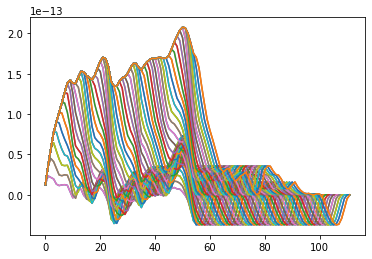

In [124]:
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), np.ones(len(ds_emis_gmean['SEA']))*ds_emis_gmean['SEA'][30].values, dt = dt)
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), ds_emis_gmean['SEA'], dt = dt)


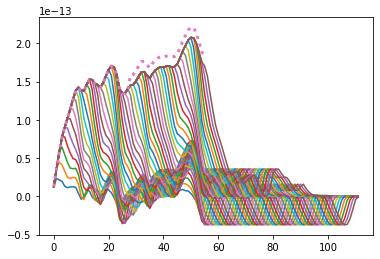

In [127]:
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), np.ones(len(ds_emis_gmean['SEA']))*ds_emis_gmean['SEA'][55].values, dt = dt)
plt.plot((utils.global_w_mean(ds_conc.sel(run = 'SEA_2x').fillna(0), poll_name)-
            utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name)), linestyle = ':', linewidth = 3)

array([570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 5

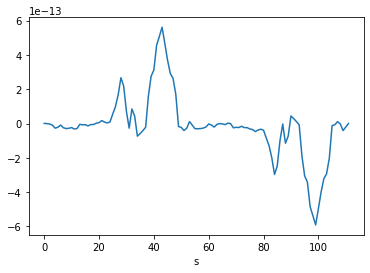

In [35]:
out_mean['SEA'].plot()